# Определение возраста покупателей

**ОПИСАНИЕ ПРОЕКТА:**
Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;

Контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

Импортируем нужные библиотеки

In [1]:
from tensorflow.keras.datasets import fashion_mnist 
from tensorflow.keras.layers import Dense, Conv2D, AvgPool2D, Flatten, GlobalAveragePooling2D, Dropout 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.applications.resnet import ResNet50 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 
from tensorflow.keras.optimizers import Adam
optimizer = Adam(lr=0.0001) 

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Считаем датасет

In [2]:
try:
    labels = pd.read_csv('/datasets/faces/labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255)
except FileNotFoundError:
    labels = pd.read_csv('https://code.s3.yandex.net/datasets/faces/labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255)

In [3]:
train_gen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory='/datasets/faces/final_files/',
    x_col='file_name',
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    seed=12345
    )

Found 7591 validated image filenames.


In [4]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [5]:
labels.shape

(7591, 2)

Построим гистограмму, чтобы определить колличество фотографий для разных возрастов

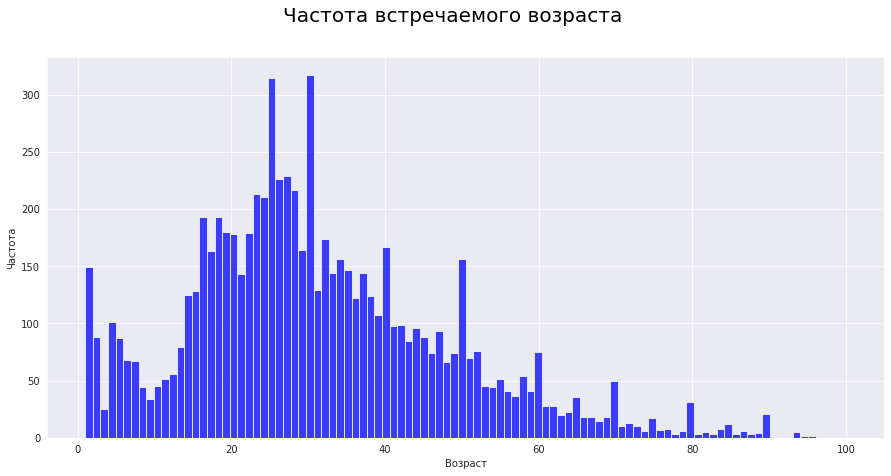

In [6]:
plt.figure(figsize=[15, 7])
plt.suptitle('Частота встречаемого возраста', fontsize=20)
sns.set_style('darkgrid')
sns.histplot(data=labels['real_age'], color='b', label='возраст',bins=100, kde=False)
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.grid(True)
plt.show();

По гистограмме можем сделать вывод, что людей старше 60 лет у нас очень мало и из-за этого у модели могут быть проблемы с обучением и определением таких людей в реальной работе нашей модели

Посмотрим на сами фотографии людей с их возрастами. Так как train_gen_flow выдаёт нам пару в виде фотографии с возрастом, то разобьём сразу на фичи и таргет. 

In [7]:
features, target = next(train_gen_flow)

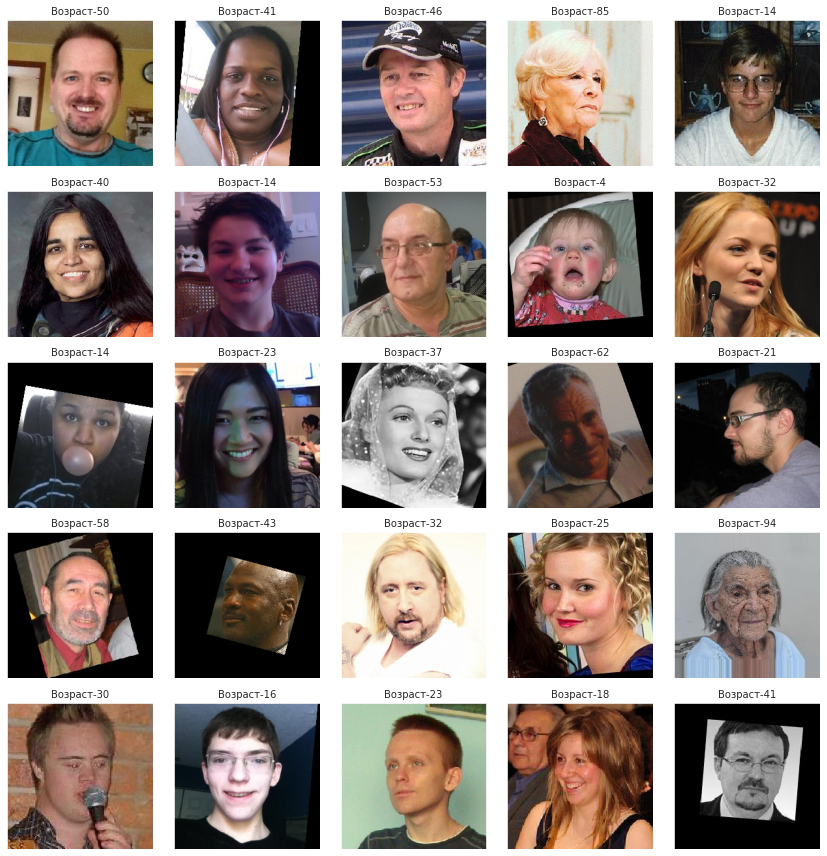

In [8]:
fig = plt.figure(figsize=(12,12))
for i in range(25):
    fig.add_subplot(5, 5, i+1)
    plt.imshow(features[i])
    plt.title(f'Возраст-{target[i]}', fontsize=10)
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Минивывод:
Мы изучили датасет и на  данном этапе можно сказать, что частота встречающихся фотографий несбалансирована: фото людей старше 60 лет встречаются намного реже нежели людей 20-30 лет. Это может оказать негативное влияние на качество обучения нашей модели. Посмотрев на сами фотографии мы видим разнообразие не только разных возрастов, но и размеров, ротаций и цветовых палитр (есть черно-белые фото). Это должно положительно повлиять на модель, обучив её распознавать возраст под любым углом вне зависимости от освещения.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

def load_train(path): 
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, 
                                       horizontal_flip=True,
                                       rescale=1/255.
                                )
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path+'final_files/',
        x_col="file_name", 
        y_col="real_age", 
        target_size=(224, 224),
        batch_size=64,
        class_mode='raw',
        subset='training',
        seed=12345)

    
    return train_datagen_flow

def load_test(path): 
    labels = pd.read_csv(path+'labels.csv')
    datagen_t = ImageDataGenerator(validation_split=0.25,
                                   rescale=1/255.
                                  )
    
    test_datagen_flow = datagen_t.flow_from_dataframe(
    dataframe=labels,
    directory=path+'final_files/',
    x_col='file_name',
    y_col='real_age',    
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    subset='validation',
    seed=12345)
  
    
    return test_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                       weights='imagenet',
                       include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(Conv2D(filters=6, 
                     kernel_size=(3, 3), 
                     input_shape=(224, 224, 3), 
                     padding='same', 
                     activation='relu'))
    model.add(AveragePooling2D())
    model.add(Flatten())

    model.add(Dense(units=1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae']) 
    return model 

def train_model(
    model, 
    train_data, 
    test_data, 
    batch_size=None, 
    epochs=10, 
    steps_per_epoch=None, 
    validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    
    model.fit(
        train_data, 
        validation_data=test_data, 
        steps_per_epoch=steps_per_epoch, 
        validation_steps=validation_steps, 
        batch_size=batch_size, 
        epochs=epochs, 
        verbose=2)
    return model

```

```
Train for 178 steps, validate for 60 steps
Epoch 1/10
2023-02-21 10:26:37.689601: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-02-21 10:26:38.100399: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 67s - loss: 243.0780 - mae: 11.0469 - val_loss: 1098.2893 - val_mae: 28.5891
Epoch 2/10
178/178 - 40s - loss: 76.8805 - mae: 6.6024 - val_loss: 958.0853 - val_mae: 26.1708
Epoch 3/10
178/178 - 38s - loss: 49.2984 - mae: 5.3654 - val_loss: 446.8395 - val_mae: 15.6851
Epoch 4/10
178/178 - 40s - loss: 36.2441 - mae: 4.5381 - val_loss: 145.7762 - val_mae: 9.4626
Epoch 5/10
178/178 - 38s - loss: 25.6705 - mae: 3.8776 - val_loss: 79.6126 - val_mae: 6.8399
Epoch 6/10
178/178 - 40s - loss: 21.1282 - mae: 3.5047 - val_loss: 68.4445 - val_mae: 6.1552
Epoch 7/10
178/178 - 40s - loss: 16.9849 - mae: 3.1485 - val_loss: 65.3613 - val_mae: 6.1208
Epoch 8/10
178/178 - 38s - loss: 14.5794 - mae: 2.9312 - val_loss: 62.9911 - val_mae: 5.9544
Epoch 9/10
178/178 - 38s - loss: 11.7956 - mae: 2.6248 - val_loss: 62.0499 - val_mae: 5.7803
Epoch 10/10
178/178 - 38s - loss: 10.7139 - mae: 2.4834 - val_loss: 60.5190 - val_mae: 5.8471
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 60.5190 - mae: 5.8471
Test MAE: 5.8471

```

**Результат получился меньше 7 и это хорошо)**

## Анализ обученной модели

Для получения наилучшего качества модели мы использовали алгоритм Adam с частотой обучения lr=0.0001, архитектуру RestNet50 с количеством эпох 10. Метрика MAE < 7, значит поставленной цели мы достигли. Однако больше всего изображений 25 лет и 30 лет, и после отметки 60 данных мало - это потенциально сужает способности нейросети и создает ограничения в точности за пределами лиц, заявленной категории.